## Manually colapse the events in images 

Collapse the events in the frames to get the most active pixels and get an 'artificial brightnest' of the image 


In [5]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *
from lib.real_time_video import *

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

import cv2

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
path = "../data/recordings/22_04/ra_60to60_de_60to80_1s.raw"
# path = "../data/recordings/02_02/recording_2024-02-02_17-26-59_FOV11.8_MAG6.raw"

mv_iterator = EventsIterator(input_path=path, delta_t=10000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=10000)


# frames = np.random.randint(0, 256, size=(1, height, width), dtype=np.uint8)
frames = np.empty((0, height, width), dtype=np.uint8) 

def on_cd_frame_cb(ts, cd_frame):
    global frames  # Add this line to access the global frames variable
    gray_frame = np.reshape(cv2.cvtColor(cd_frame, cv2.COLOR_BGR2GRAY), (1, height, width))
    frames = np.append(frames,gray_frame, axis=0)  # Append the gray_frame as a new row to the frames array
    

event_frame_gen.set_output_callback(on_cd_frame_cb)

for evs in mv_iterator:
    event_frame_gen.process_events(evs)
    if len(frames) > 1000:
        break 

print(frames.shape)


(239, 720, 1280)


In [13]:
# Compact the frames

max_buffer = 10
# blend = np.array(np.zeros((cv2.cvtColor(np.array(frames[0]), cv2.COLOR_BGR2GRAY).shape)))
copact_frames = []
frames_buffer = np.empty((0, height, width), dtype=np.uint8) 


st = time.perf_counter()
for i, _ in enumerate(frames):
    frames_buffer = np.append(frames_buffer, np.reshape(frames[i], (1, height, width)), axis=0)
    if frames_buffer.shape[0] == max_buffer:
        blend = blend_buffer(frames_buffer, mirror=True)
        copact_frames.append(blend.astype(np.uint8))
        frames_buffer = np.empty((0, height, width), dtype=np.uint8) 
print((time.perf_counter() - st)/frames.shape[0])


print(len(copact_frames))

0.0016588931882846028
23


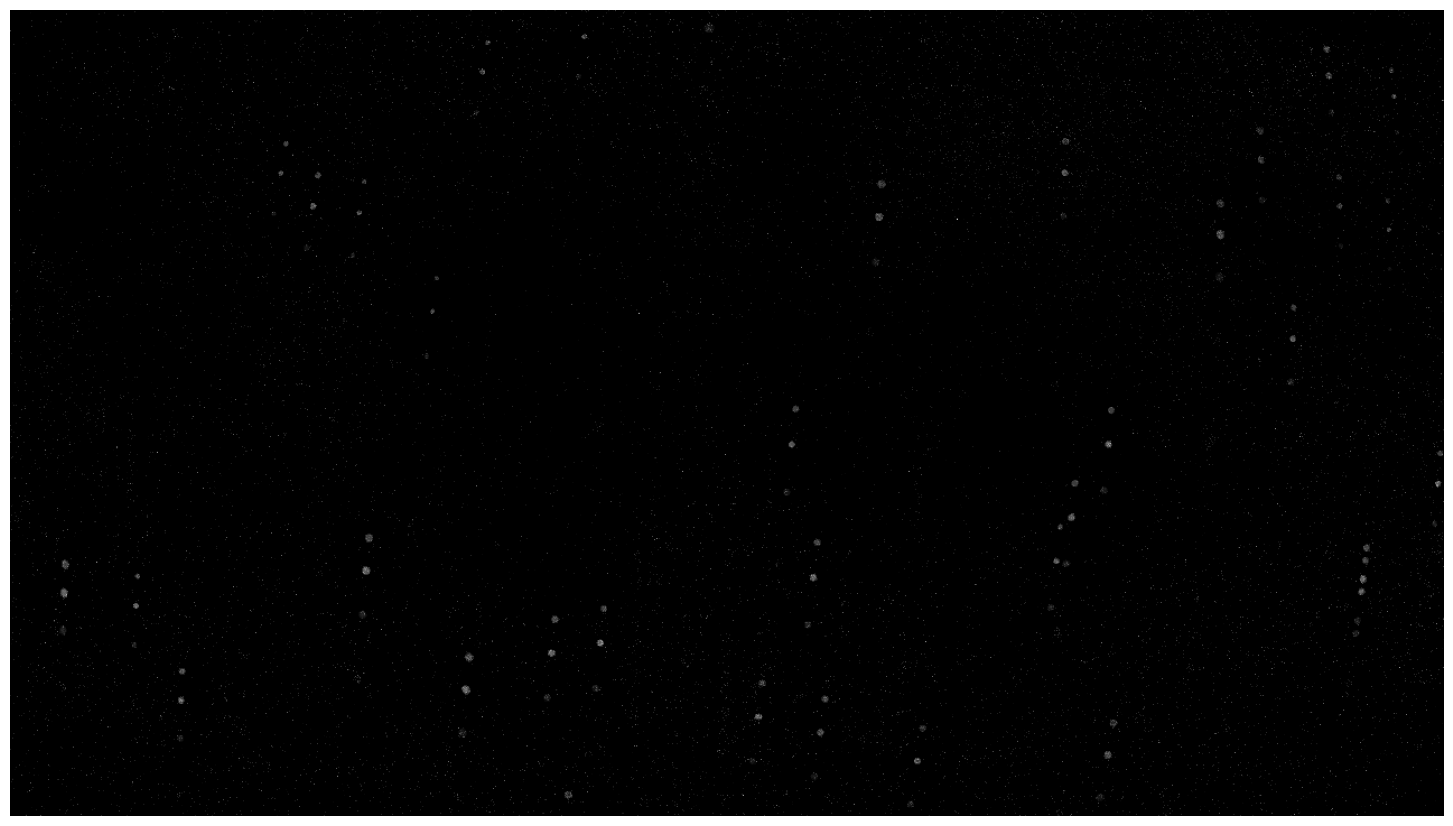

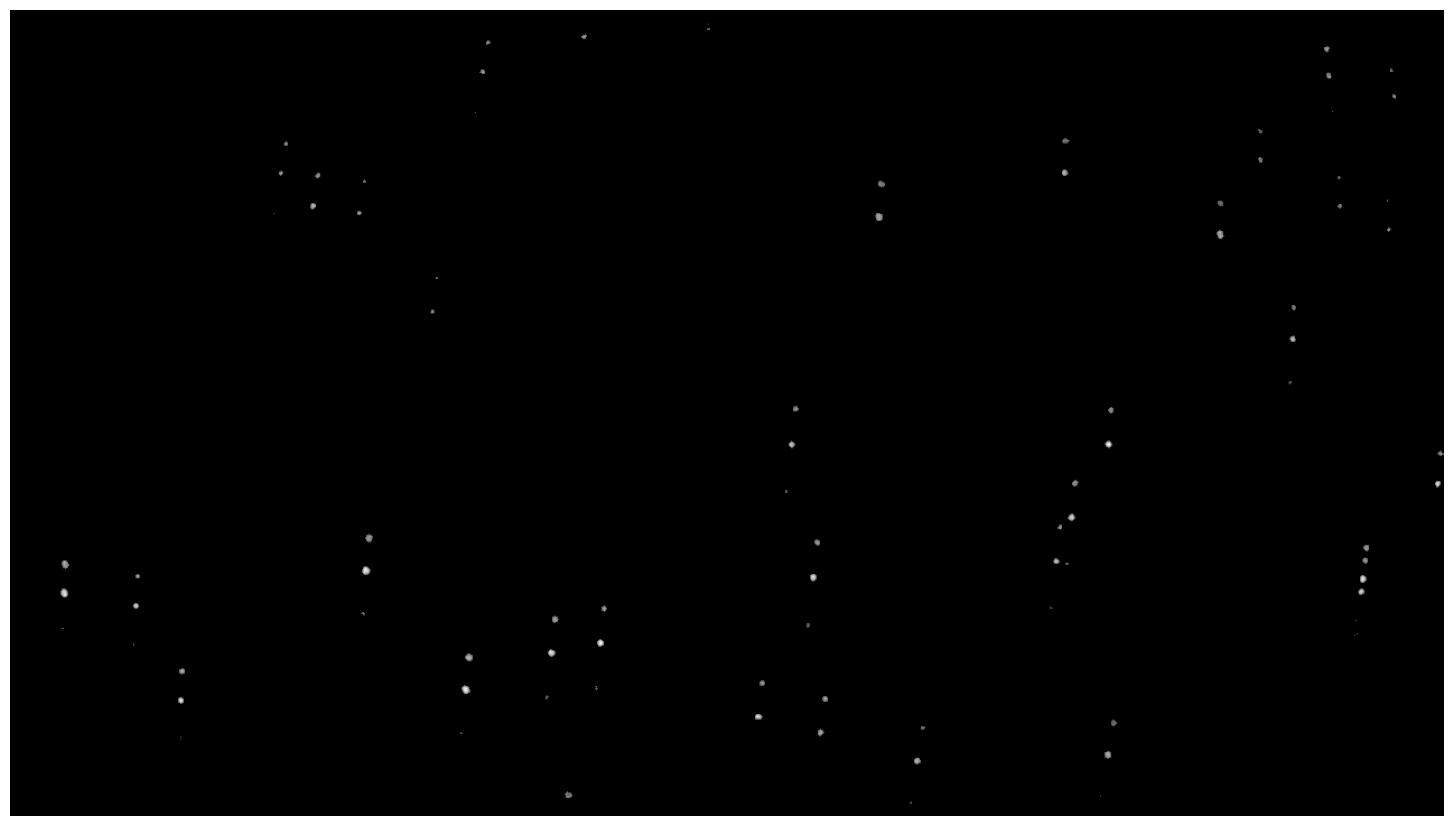

In [22]:
plot_image(copact_frames[15])

frame = copact_frames[15]
frame = cv2.blur(frame,(3,3))
frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

max_val = np.max(frame)
frame_thr = cv2.threshold(frame, max_val*0.3, 1, cv2.THRESH_TOZERO)[1]
plot_image(frame_thr)


In [19]:
from lib.utils import *
from lib.event_processing import *


frame_nr = 15
treshold = 0.2 # Percetange of max value 

filtered_frames = []
clusters_list = []
pixel_range = 5

frame = copact_frames[frame_nr]

frame = cv2.blur(frame,(3,3))
frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

max_val = np.max(frame)
frame_thr = cv2.threshold(frame, max_val*treshold, 1, cv2.THRESH_TOZERO)[1]
filtered_frames.append(frame_thr)

clusters =  max_value_cluster(frame_thr, pixel_range, 100)
clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
clusters_index = np.array([cluster[0] for cluster in clusters])
clusters_index = sorted(clusters_index, key=lambda x: x[1], reverse=True)
clusters_list.append( index_cluster(frame, pixel_range, clusters_index) )

    # print('Frame: ', index ,' Original clusters: ', len(clusters_index))

# FOR NOISY IMAGES delete the clusters with a mass lower than a treshold
mass_treshold = 0.2
treshold_val = mass_treshold*np.max([cluster_mass[1] for cluster_mass in  clusters_list[0]])
clusters_list_filtered = [cluster for cluster in clusters_list[0] if cluster[1] > treshold_val ]

print('Original clusters: ', len(clusters_list[0]),'Fitered clusters: ',  len(clusters_list_filtered))

#JUST TO CHECK SOM WITHOUT FALSE STARS
# clusters_list_filtered.pop(2) # Remove the cluster 3 of the frame 12
# clusters_list_filtered.pop(5) # Remove the cluster 7(-1) of the frame 12




Original clusters:  100 Fitered clusters:  84


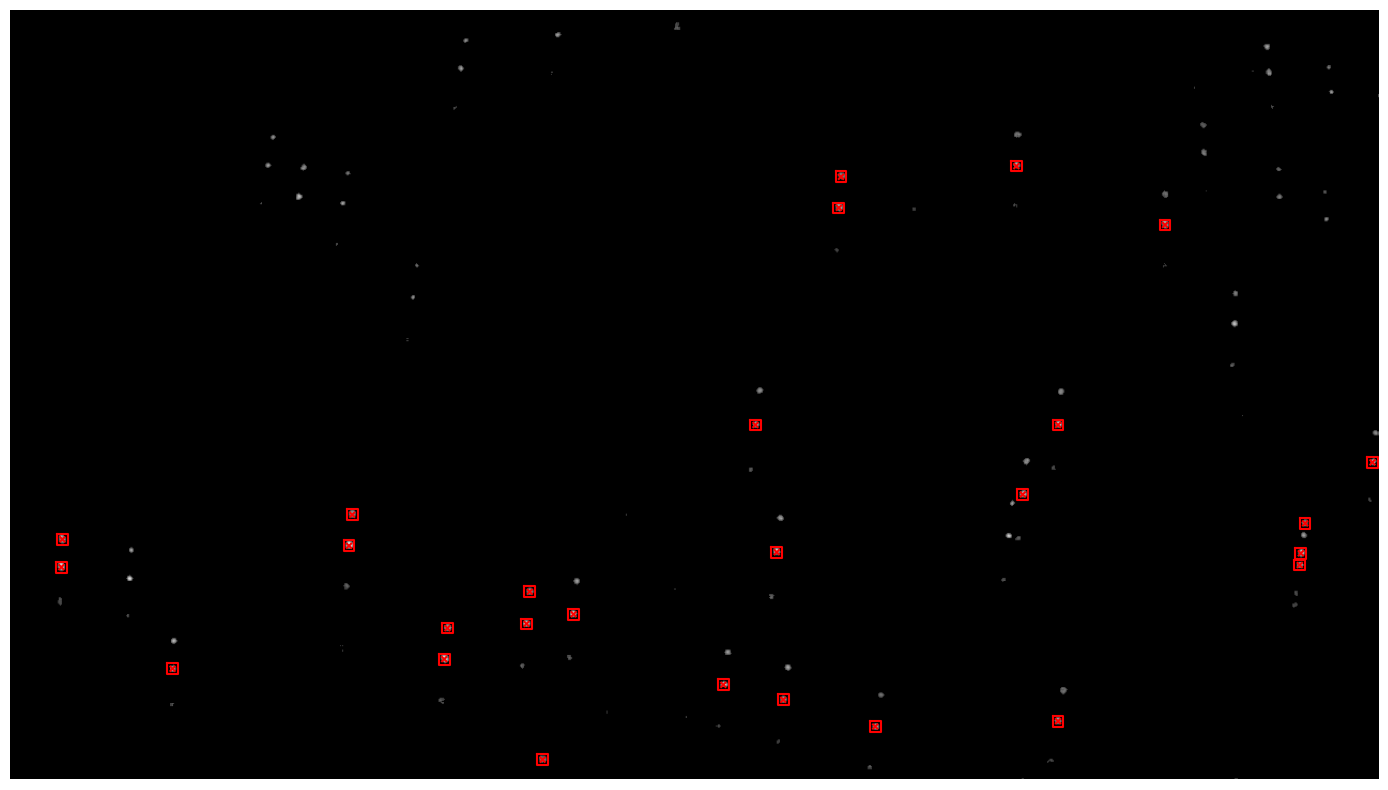

In [21]:
# FOR NOISY IMAGES delete the clusters with a mass lower than a treshold
mass_treshold = 0.5
treshold_val = mass_treshold*np.max([cluster_mass[1] for cluster_mass in  clusters_list[0]])
clusters_list_filtered = [cluster for cluster in clusters_list[0] if cluster[1] > treshold_val ]

plot_cluster(filtered_frames[0], [x[0] for x in clusters_list_filtered], pixel_range, [18.5,10])


In [67]:
8.9 / (1000*10**-6)

8900.0